In [1]:
import igraph as ig
import sknetwork as sn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from tqdm import trange, tqdm

from itertools import product
import sys
import os
sys.path.append('../')
from CAS import *

import ecg_sknetwork as ecg_sn
import ecg_igraph as ecg_igraph

In [2]:
def community_ecg(self, weights=None, ens_size = 16, min_weight = 0.05, 
                  final='louvain', resolution=1.0, refuse_score=False):
    """
    Stable ensemble-based graph clustering;
    the ensemble consists of single-level randomized Louvain; 
    each member of the ensemble gets a "vote" to determine if the edges 
    are intra-community or not;
    the votes are aggregated into ECG edge-weights in range [0,1]; 
    a final (full depth) Louvain is run using those edge weights;
    
    Parameters
    ----------
    self: graph of type 'igraph.Graph'
      Graph to define the partition on.
    weights: list of double, optional 
      the edge weights
    ens_size: int, optional
      the size of the ensemble of single-level Louvain
    min_weight: double in range [0,1], optional
      the ECG edge weight for edges with zero votes from the ensemble
    final: 'louvain' (default) or 'leiden'
      the algorithm to run on the final re-weighted graph
    resolution: positive float, optional
      resolution parameter; larger values favors smaller communities
      
    Returns
    -------
    partition
      The final partition, of type 'igraph.clustering.VertexClustering'
    partition.W
      The ECG edge weights
    partition.CSI
      The community strength index
    partition.original_modularity
      The modularity with respect to the original edge weights

    Notes
    -----
    The ECG edge weight function is defined as:
      
      min_weight + ( 1 - min_weight ) x (#votes_in_ensemble) / ens_size
      
    Edges outside the 2-core are assigned 'min_weight'.
    
    Examples
    --------
    >>> g = igraph.Graph.Famous('Zachary')
    >>> part = g.community_ecg(ens_size=25, min_weight = .1)
    >>> print(part.CSI)
    
    Reference
    ---------
    Valérie Poulin and François Théberge, "Ensemble clustering for graphs: comparisons and applications", Appl Netw Sci 4, 51 (2019). 
    https://doi.org/10.1007/s41109-019-0162-z
    """
    W = [0]*self.ecount()
    ## Ensemble of level-1 Louvain
    for i in range(ens_size):
        p = np.random.permutation(self.vcount()).tolist()
        g = self.permute_vertices(p)
        l1 = g.community_multilevel(weights=weights, return_levels=True)[0].membership
        b = [l1[p[x.tuple[0]]]==l1[p[x.tuple[1]]] for x in self.es]
        W = [W[i]+b[i] for i in range(len(W))]
    W = [min_weight + (1-min_weight)*W[i]/ens_size for i in range(len(W))]
    ## Force min_weight outside 2-core
    core = self.shell_index()
    ecore = [min(core[x.tuple[0]],core[x.tuple[1]]) for x in self.es]
    w = [W[i] if ecore[i]>1 else min_weight for i in range(len(ecore))]
    if final=='leiden':
        part = self.community_leiden(weights=w, objective_function='modularity', resolution=resolution)
    else:
        part = self.community_multilevel(weights=w, resolution=resolution)
    part.W = W
    part.CSI = 1-2*np.sum([min(1-i,i) for i in W])/len(W)
    part._modularity_params['weights'] = weights
    part.recalculate_modularity()
    
    ## experimental - "refuse to cluster" scores
    if refuse_score:
        self.vs['_deg'] = self.degree()
        self.es['_W'] = part.W
        self.vs['_ecg'] = part.membership
        for v in self.vs:
            scr = 0
            my_comm = v['_ecg']
            good = 0
            bad = 0
            for e in v.incident():
                scr += e['_W']
                if self.vs[e.source]['_ecg'] == self.vs[e.target]['_ecg']:
                    good += e['_W']
                else:
                    bad += e['_W']
            v['_overall'] = ((v['_deg']-scr)/v['_deg'])
            v['_community'] = (bad/(bad+good))        
        part.refuse_overall = self.vs['_overall']
        part.refuse_community = self.vs['_community']
        del(self.vs['_deg'])
        del(self.es['_W'])
        del(self.vs['_ecg'])
        del(self.vs['_overall'])
        del(self.vs['_community'])            
    ## end experimental scores
    
    return part

ig.Graph.community_ecg = community_ecg

## Code to generate ABCD-o graphs (currently requires julia)

In [3]:
# ABCD+o only in Julia for now - update path below as needed

## local:
# abcd_path = '/Users/francois/ABCD/ABCDo/ABCDGraphGenerator.jl/utils/'
# julia = '/Applications/Julia-1.7.app/Contents/Resources/julia/bin/julia '

## Dev02:
abcd_path = '/home/rdewolfe/research/ABCDGraphGenerator.jl/utils/'
julia = '/home/rdewolfe/.juliaup/bin/julia '

def _run_julia_abcd(n=1000, xi=0.3, delta=5, zeta=0.5, gamma=2.5, s=25, tau=0.825, beta=1.5, seed=123, nout=0):
    D = int(n**zeta)
    S = int(n**tau) 
    rdm = str(np.random.choice(100000))
    fn_deg = 'deg_'+rdm+'.dat'
    fn_cs = 'cs_'+rdm+'.dat'
    fn_comm = 'comm_'+rdm+'.dat'
    fn_net = 'net_'+rdm+'.dat'
    ## generate graph
    cmd = julia+abcd_path+'deg_sampler.jl '+fn_deg+' '+str(gamma)+' '+str(delta)+' '+str(D)+' '+str(n)+' 1000 '+str(seed)
    os.system(cmd+' >/dev/null 2>&1')
    cmd = julia+abcd_path+'com_sampler.jl '+fn_cs+' '+str(beta)+' '+str(s)+' '+str(S)+' '+str(n)+' 1000 '+str(seed)+' '+str(nout)
    os.system(cmd+' >/dev/null 2>&1')
    cmd = julia+abcd_path+'graph_sampler.jl '+fn_net+' '+fn_comm+' '+fn_deg+' '+fn_cs+' xi '+str(xi)+' false false '+str(seed)+' '+str(nout)
    os.system(cmd+' >/dev/null 2>&1')
    ## load edges
    edges = np.loadtxt(fn_net, dtype='int32')
    g = sn.data.from_edge_list(edges - 1)  # Make 0 indexed
    ## ground-truth communities
    c = np.loadtxt(fn_comm,dtype='int32',usecols=(1))
    c = c-1  # make 0 indexed
    cmd = 'rm *_'+rdm+'.dat'
    os.system(cmd+' >/dev/null 2>&1')
    return g, c

## Test if CAS scores can weight edges well using ground truth communities

  0%|          | 0/5 [00:04<?, ?it/s]

Got graph
Got is internal




KeyboardInterrupt



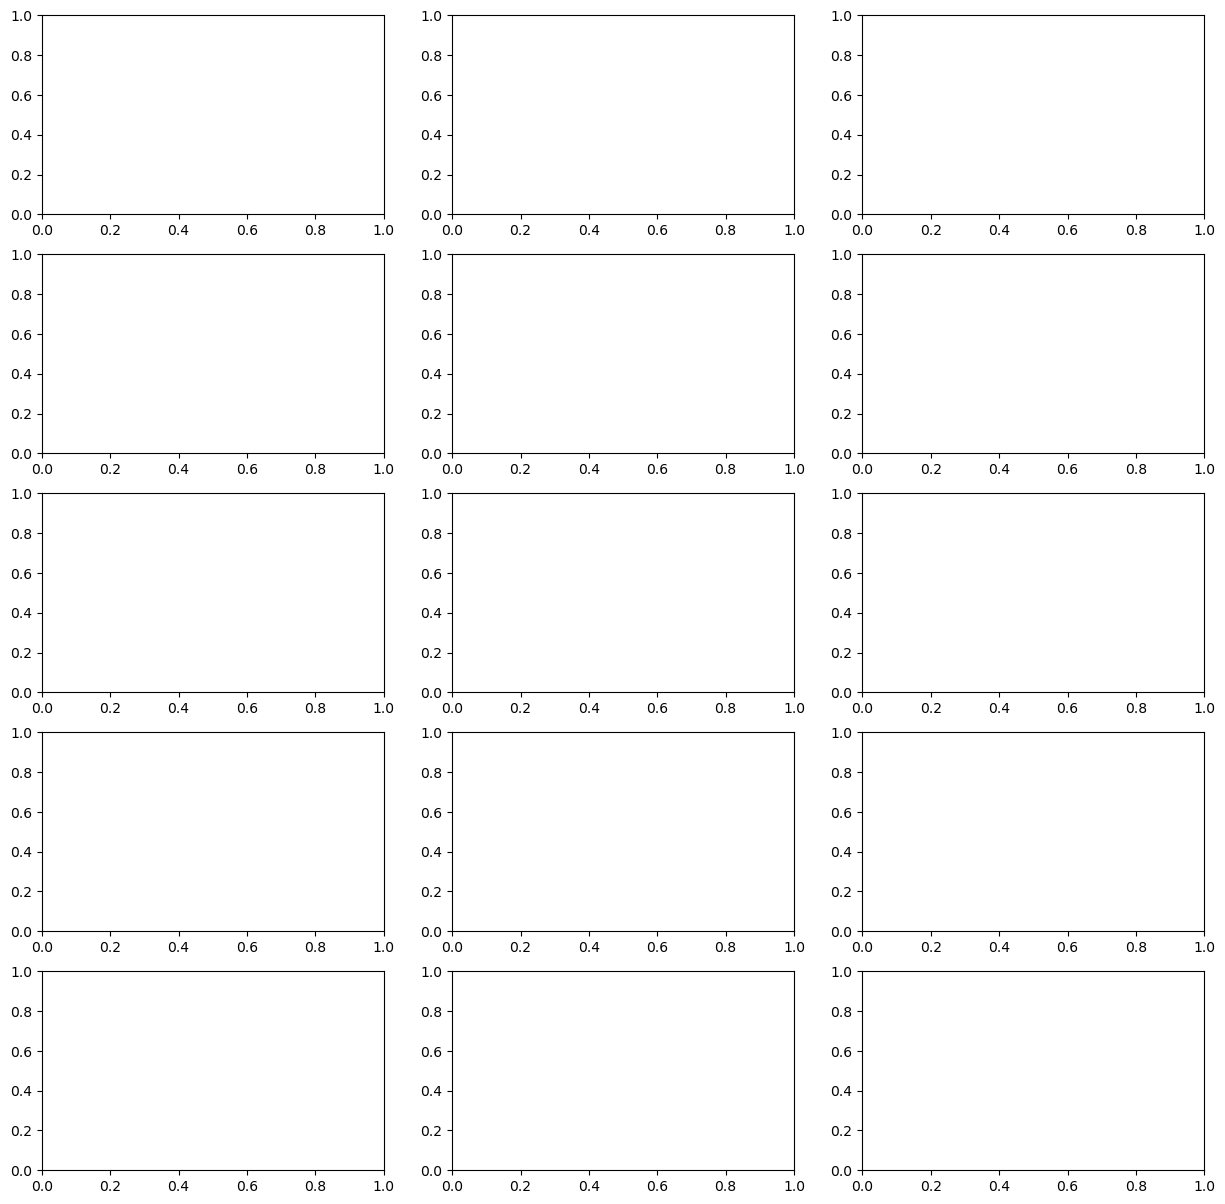

In [6]:
## first with "mid-size" graphs
num_nodes = 10000
num_out = 0
delta = 5
min_comm = 100


XIs = [.5, .6, .7, .8, .9]
fig, axs = plt.subplots(len(XIs), 3, figsize=(15, 3*len(XIs)))
for i in trange(len(XIs)):
    xi = XIs[i]
    g, c = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, 
                            zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)
    print("Got graph")
    is_internal = ecg_sn.is_internal_edge(g.indptr, g.indices, c)
    print("Got is internal")
    weights = ecg_sn.compute_edge_weights(g.indptr, g.indices, ecg_sn.ief_to_cluster, c)
    print("Got weights")
    axs[i,0].hist(weights[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 0].hist(weights[is_internal == False], label="External", alpha=0.7)
    axs[i, 0].set_xlabel("Edge Weight")
    axs[i, 0].set_title("IEF")
    axs[i, 0].legend()
    axs[i, 0].set_ylabel(r'$\xi$ ='+str(xi))

    weights = ecg_sn.compute_edge_weights(g.indptr, g.indices, ecg_sn.nief_to_cluster, c)
    axs[i, 1].hist(weights[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 1].hist(weights[is_internal == False], label="External", alpha=0.7)
    axs[i, 1].set_xlabel("Edge Weight")
    axs[i, 1].set_title("NIEF")

    weights = ecg_sn.compute_edge_weights(g.indptr, g.indices, ecg_sn.p_to_cluster, c)
    axs[i, 2].hist(weights[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 2].hist(weights[is_internal == False], label="External", alpha=0.7)
    axs[i, 2].set_xlabel("Edge Weight")
    axs[i, 2].set_title(f"P")


100%|██████████| 9/9 [01:31<00:00, 10.21s/it]


Text(0.5, 0.98, 'CAS-ECG ground truth ROC curves')

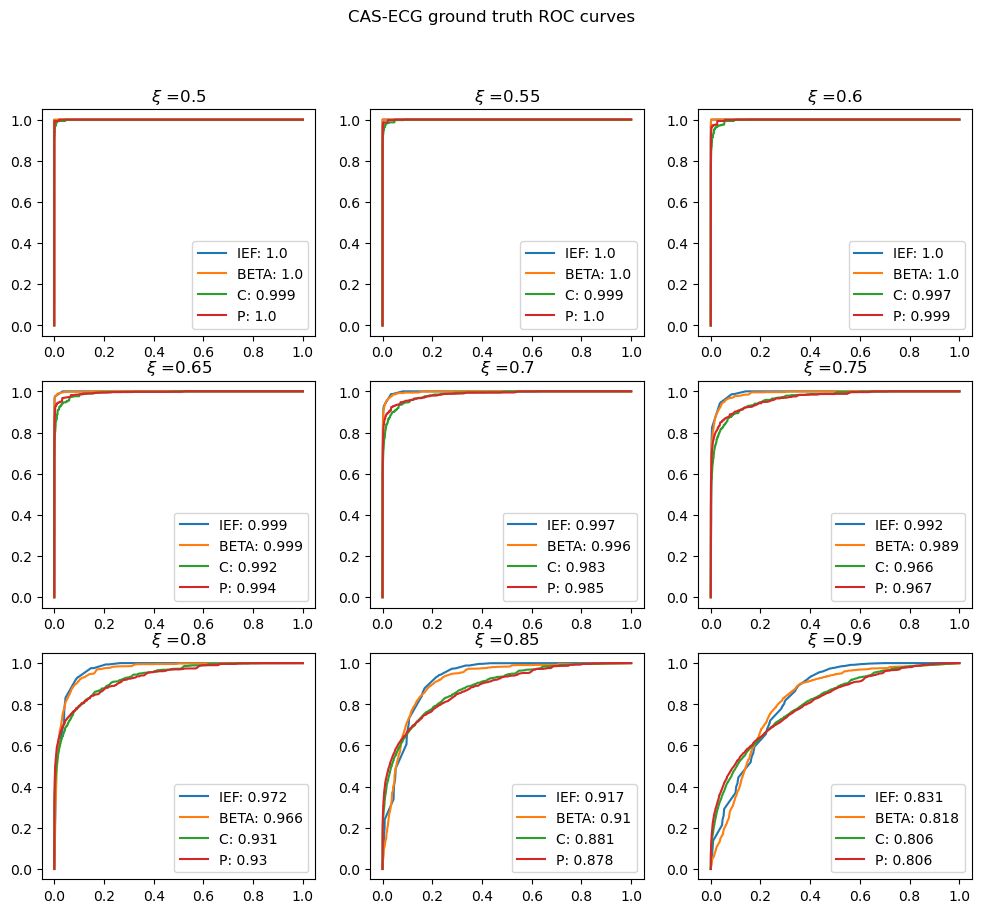

In [9]:
# AUCROC curves for edge weight predicting is-internal
XIs = [.5, .55, .6, .65, .7, .75, .8, .85, .9]
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
for i in trange(len(XIs)):
    xi = XIs[i]
    plt.subplot(3,3,i+1)
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)

    gt = np.array(g.vs["gt"])
    ief, beta, c, p, ecg = ecg_igraph.cas_edge_weights(g, gt)
    is_internal = np.array([g.vs[e.source]["gt"] == g.vs[e.target]["gt"] for e in g.es], dtype="bool")

    fpr, tpr, thresholds = roc_curve(is_internal, ief, pos_label=1)
    plt.plot(fpr, tpr, label='IEF: '+str(round(AUC(is_internal, ief),3)))

    fpr, tpr, thresholds = roc_curve(is_internal, beta, pos_label=1)
    plt.plot(fpr, tpr, label='BETA: '+str(round(AUC(is_internal, beta),3)))

    fpr, tpr, thresholds = roc_curve(is_internal, c, pos_label=1)
    plt.plot(fpr, tpr, label='C: '+str(round(AUC(is_internal, c),3)))

    fpr, tpr, thresholds = roc_curve(is_internal, p, pos_label=1)
    plt.plot(fpr, tpr, label='P: '+str(round(AUC(is_internal, p),3)))

    plt.title(r'$\xi$ ='+str(xi))
    plt.legend()
    

plt.suptitle("CAS-ECG ground truth ROC curves")

## Test if the Ensemble edge-weights can perform similarily

100%|██████████| 5/5 [00:52<00:00, 10.50s/it]


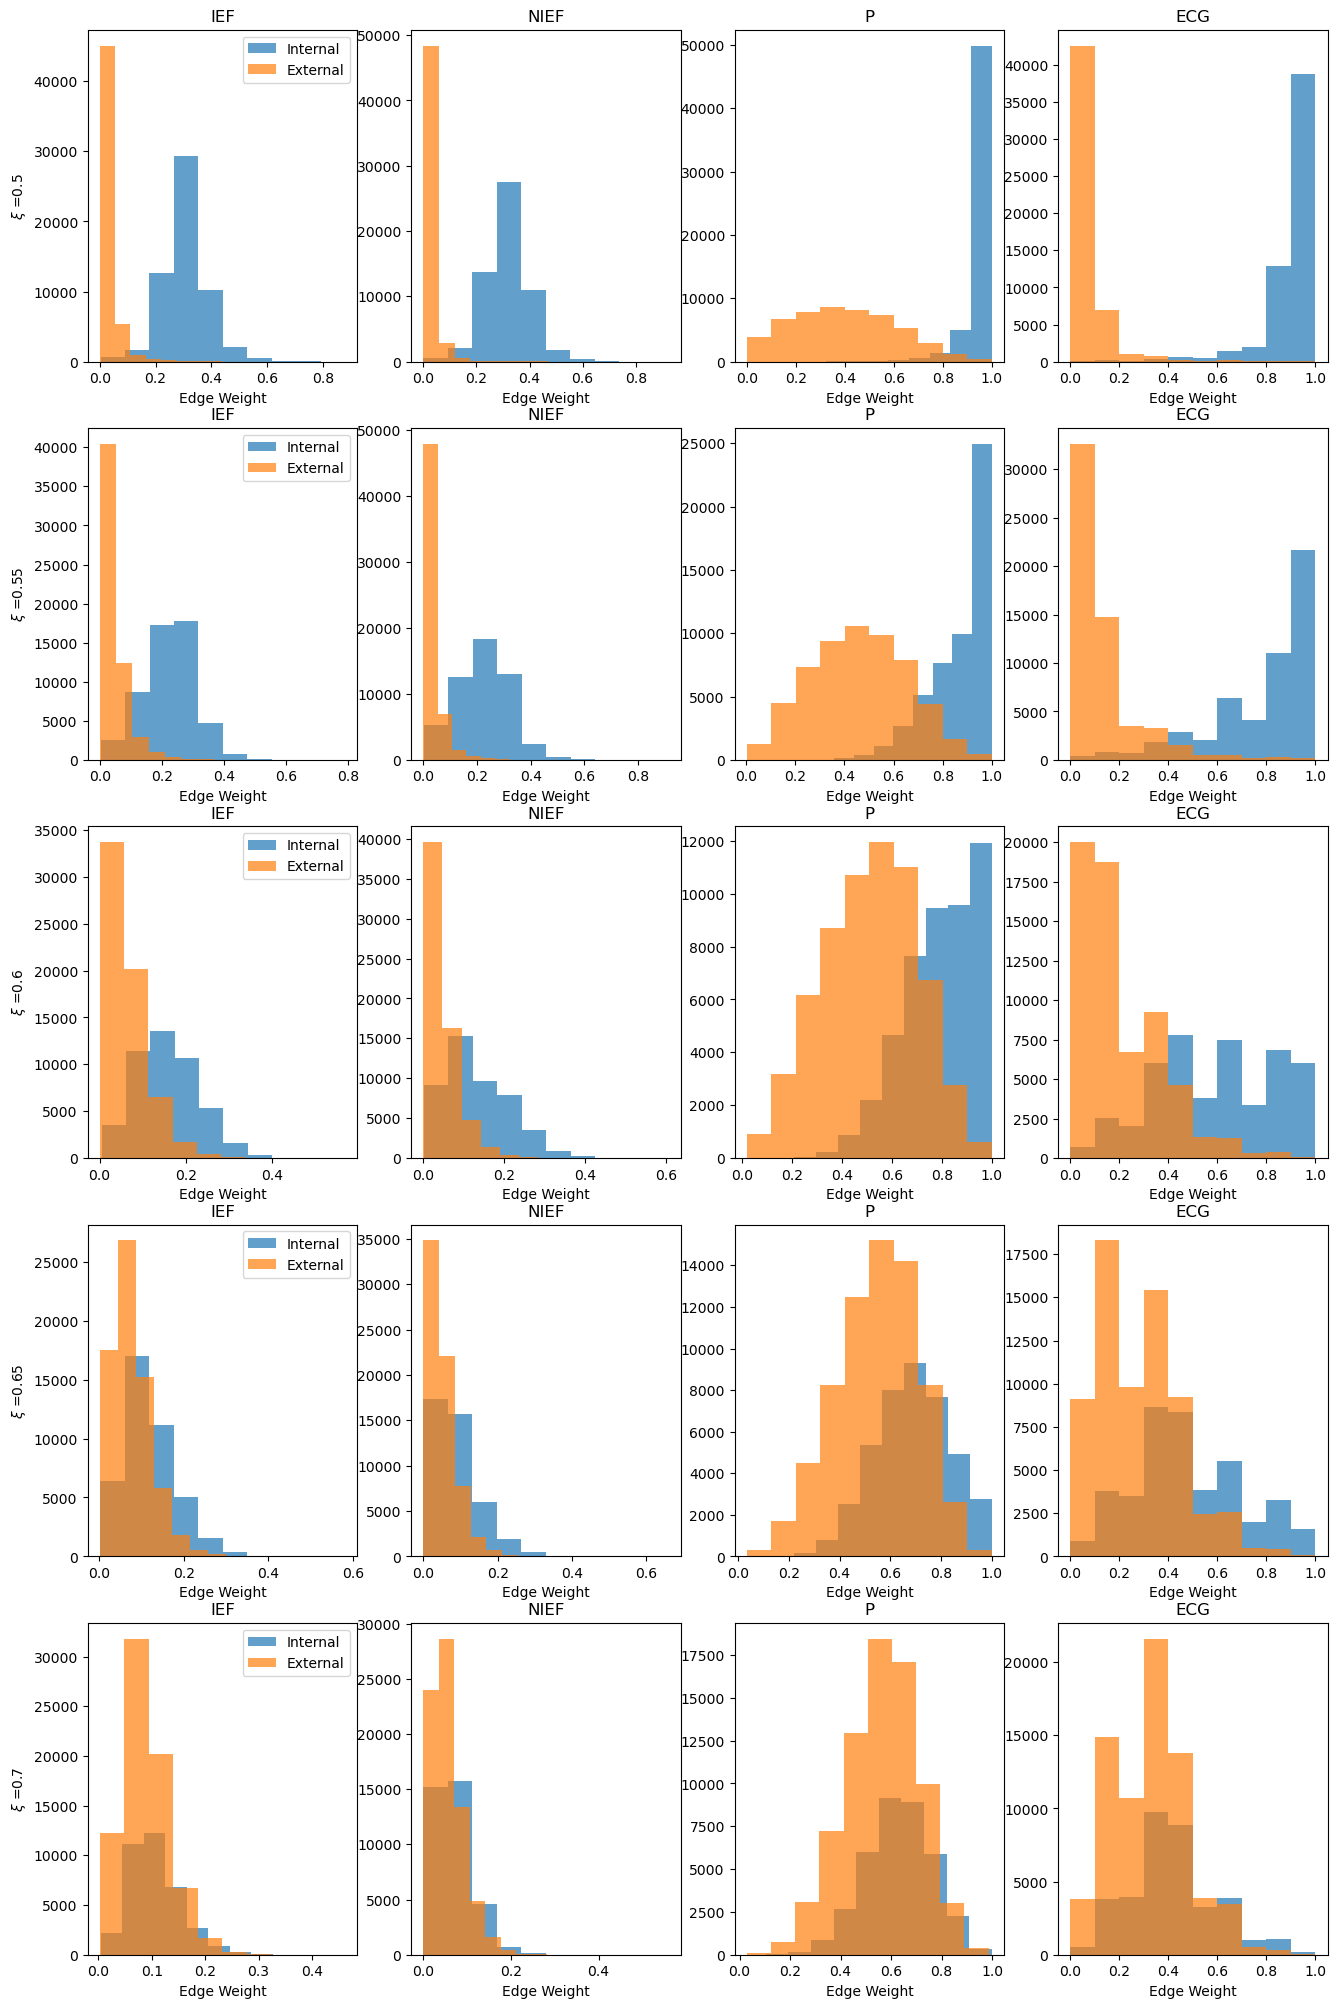

In [4]:
## first with "mid-size" graphs
num_nodes = 10000
num_out = 0
delta = 5
min_comm = 100
alpha = 1


XIs = [.5, .55, .6, .65, .7]
fig, axs = plt.subplots(len(XIs), 4, figsize=(16, 5*len(XIs)))
for i in trange(len(XIs)):
    xi = XIs[i]
    g, c = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)
    is_internal = ecg_sn.is_internal_edge(g.indptr, g.indices, c)

    weights = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ief_to_cluster)
    axs[i,0].hist(weights[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 0].hist(weights[is_internal == False], label="External", alpha=0.7)
    axs[i, 0].set_xlabel("Edge Weight")
    axs[i, 0].set_title("IEF")
    axs[i, 0].legend()
    axs[i, 0].set_ylabel(r'$\xi$ ='+str(xi))

    weights = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.nief_to_cluster)
    axs[i, 1].hist(weights[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 1].hist(weights[is_internal == False], label="External", alpha=0.7)
    axs[i, 1].set_xlabel("Edge Weight")
    axs[i, 1].set_title("NIEF")

    weights = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
    axs[i, 2].hist(weights[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 2].hist(weights[is_internal == False], label="External", alpha=0.7)
    axs[i, 2].set_xlabel("Edge Weight")
    axs[i, 2].set_title(f"P")

    weights = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)
    axs[i, 3].hist(weights[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 3].hist(weights[is_internal == False], label="External", alpha=0.7)
    axs[i, 3].set_xlabel("Edge Weight")
    axs[i, 3].set_title(f"ECG")

100%|██████████| 9/9 [01:28<00:00,  9.82s/it]


Text(0.5, 0.98, 'CAS-ECG ground truth ROC curves')

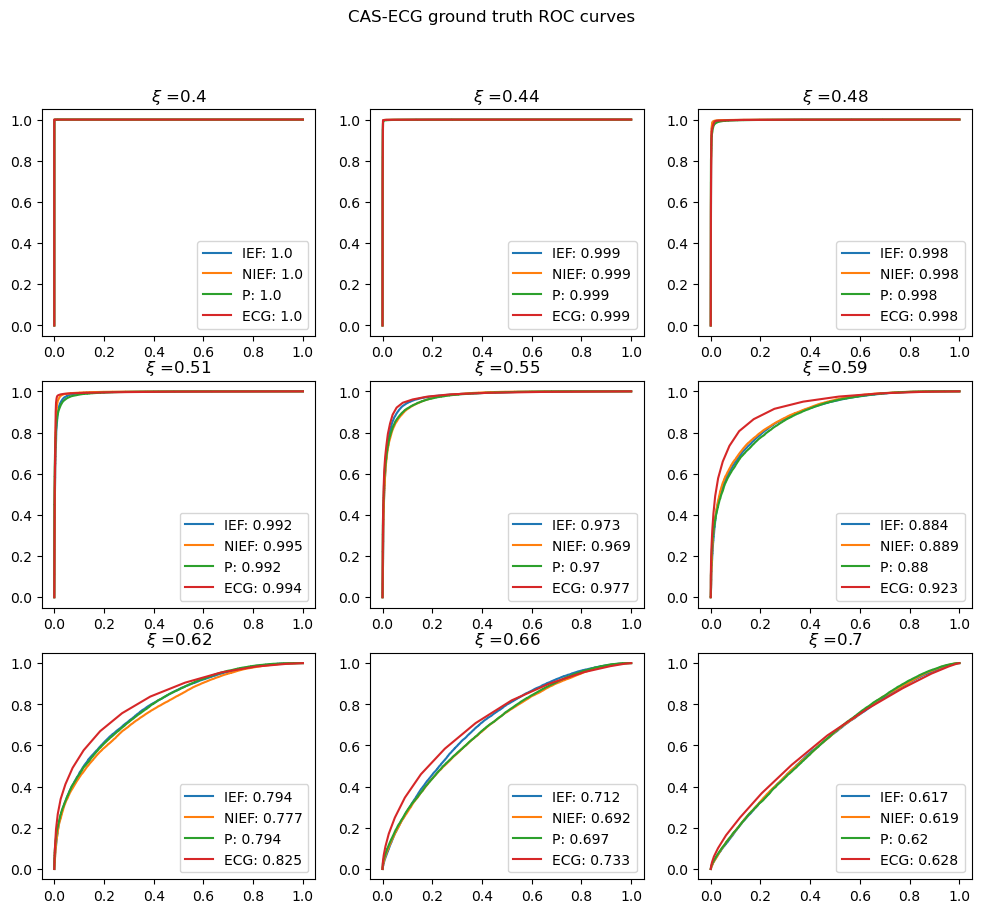

In [5]:
# ROC curves for edge weight predicting is-internal
XIs = np.linspace(.4, .7, 9)
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
for i in trange(len(XIs)):
    xi = XIs[i]
    plt.subplot(3,3,i+1)
    g, c = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)
    is_internal = ecg_sn.is_internal_edge(g.indptr, g.indices, c)

    options = [
        ["IEF", ecg_sn.ief_to_cluster],
        ["NIEF", ecg_sn.nief_to_cluster],
        ["P", ecg_sn.p_to_cluster],
        ["ECG", ecg_sn.ecg_to_cluster]
    ]
    for name, cas in options:
        weights = ecg_sn.ensemble_cas_edge_weights(g, cas, combine_function="mean", normalize=False)
        fpr, tpr, thresholds = roc_curve(is_internal, weights, pos_label=1)
        plt.plot(fpr, tpr, label=name+': '+str(round(AUC(is_internal, weights),3)))

    # weights = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.nief_to_cluster, combine_function="mean", normalize=False)
    # fpr, tpr, thresholds = roc_curve(is_internal, weights, pos_label=1)
    # plt.plot(fpr, tpr, label='NIEF: '+str(round(AUC(is_internal, weights),3)))

    # weights = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster, combine_function="mean", normalize=False)
    # fpr, tpr, thresholds = roc_curve(is_internal, weights, pos_label=1)
    # plt.plot(fpr, tpr, label='P: '+str(round(AUC(is_internal, weights), 3)))

    # weights = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster, combine_function="mean", normalize=False)
    # fpr, tpr, thresholds = roc_curve(is_internal, weights, pos_label=1)
    # plt.plot(fpr, tpr, label='ECG: '+str(round(AUC(is_internal, weights), 3)))

    plt.title(r'$\xi$ ='+str(round(xi, 2)))
    plt.legend()
    

plt.suptitle("CAS-ECG ground truth ROC curves")

## A small benchmark for CAS-ECG clustering

In [13]:
## first with "mid-size" graphs
REP = 10
num_nodes = 5000
num_out = 0
delta = 5
min_comm = 100
alpha = 1

XIs = np.linspace(.45, .7, 8)
data = []
with tqdm(total = len(XIs)*REP) as pbar:
    for xi, rep in product(XIs, range(REP)):
        g, c = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, s=min_comm, tau = 0.767)
        options = [
            ["IEF", ecg_sn.ief_to_cluster],
            ["NIEF", ecg_sn.nief_to_cluster],
            ["P", ecg_sn.p_to_cluster],
            ["ECG", ecg_sn.ecg_to_cluster]
        ]
        for name, cas in options:
            weights = ecg_sn.ensemble_cas_edge_weights(g, cas, combine_function="and", normalize=False)
            clustering = ecg_sn.cluster_edges(g, weights)
            data.append([name, xi, rep, AMI(c, clustering)])
        
        # Include reference ecg implementation
        igg = ig.Graph.Adjacency(g, mode="undirected")
        ref_ecg = igg.community_ecg(final="leiden").membership
        data.append(["REF ECG", xi, rep, AMI(c, ref_ecg)])

        weights = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster, combine_function="and", normalize=False)
        g.data = weights
        igg = ig.Graph.Weighted_Adjacency(g, mode="undirected")
        m = igg.community_leiden(weights=igg.es["weight"], objective_function='modularity', resolution=1.0).membership
        data.append(["P IG", xi, rep, AMI(c, m)])

        pbar.update()
pbar.close()

100%|██████████| 100/100 [17:43<00:00, 10.64s/it]


Text(0, 0.5, 'AMI')

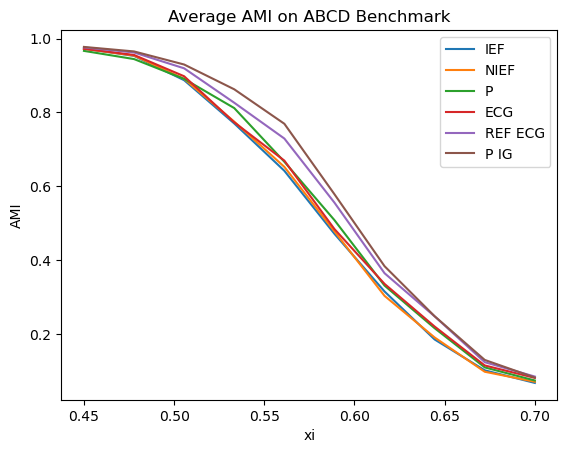

In [15]:
df = pd.DataFrame(data, columns=['name','xi', 'rep', 'score'])
D = df.groupby(['name', "xi"])["score"].mean()

for name in df["name"].unique():
    xis = D[name].index.values
    scores = D[name].values
    plt.plot(xis, scores, label=name)
plt.title("Average AMI on ABCD Benchmark")
plt.legend()
plt.xlabel("xi")
plt.ylabel("AMI")

Text(0, 0.5, 'Difference in average AMI to REF ECG')

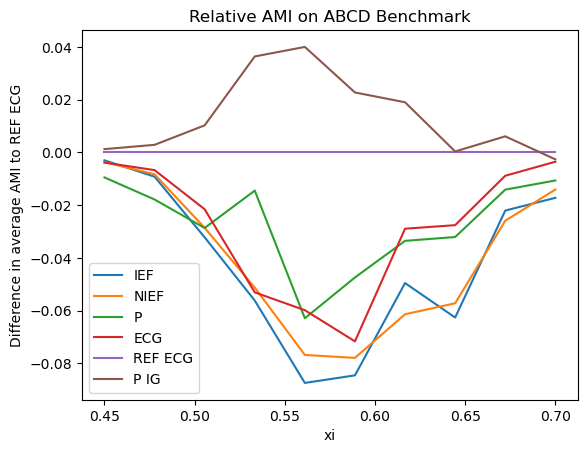

In [39]:
baseline = D["REF ECG"].values

for name in df["name"].unique():
    xis = D[name].index.values
    scores = D[name].values - baseline
    plt.plot(xis, scores, label=name)
plt.title("Relative AMI on ABCD Benchmark")
plt.legend()
plt.xlabel("xi")
plt.ylabel("Difference in average AMI to REF ECG")

Text(0, 0.5, 'Average difference in AMI to REF ECG')

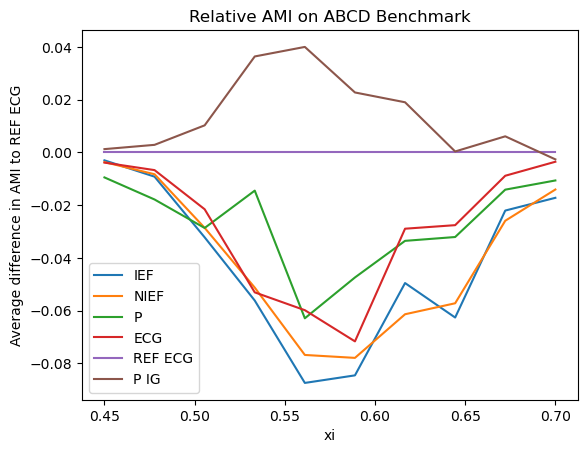

In [38]:
def make_score_array(df, xis, name):
    this_name = df[df['name'] == name]
    xis = df['xi'].unique()
    reps = df['rep'].unique()
    scores = np.empty((len(xis), len(reps)), dtype='float64')
    for i, xi in enumerate(xis):
        for j in reps:
            scores[i, j] = this_name.loc[(this_name['rep'] == j) & (this_name['xi'] == xi)].score.values[0]
    return scores


xis = df['xi'].unique()
baseline = make_score_array(df, xis, "REF ECG")
for name in df["name"].unique():
    scores = make_score_array(df, xis, name)
    mean_diff = np.mean(scores - baseline, axis=1)
    plt.plot(xis, mean_diff, label=name)
plt.title("Relative AMI on ABCD Benchmark")
plt.legend()
plt.xlabel("xi")
plt.ylabel("Average difference in AMI to REF ECG")

In [40]:
for name in df["name"].unique():
    xis = D[name].index.values
    scores = D[name].values
    print(f"{name}: {scores}")

IEF: [0.97315148 0.95311476 0.88724652 0.76999738 0.64179992 0.4709907
 0.31475821 0.18475007 0.10118557 0.06705976]
NIEF: [0.97248024 0.95403722 0.89085363 0.77490993 0.6524054  0.47762186
 0.30292733 0.19015628 0.09732286 0.07020581]
P: [0.9666732  0.94445966 0.89079466 0.81168383 0.66631483 0.50811953
 0.33076192 0.2152809  0.10911437 0.07364233]
ECG: [0.97228995 0.95559928 0.89789532 0.77309912 0.66938538 0.48388327
 0.33536938 0.21977591 0.1143874  0.08073907]
REF ECG: [0.97613195 0.96228852 0.91942605 0.82614796 0.7291917  0.55551751
 0.3642765  0.24734171 0.12321362 0.08425518]
P IG: [0.97740552 0.96518247 0.92971557 0.86256327 0.76922129 0.57827556
 0.38331604 0.24772179 0.12933848 0.08164212]
